## Notebook to ID the location of the polar front based on the Barton et al diagnostics

We will use this for future regional analysis

In [1]:
# import packages and functions
# define figure path to save lots of figures - we choose relevant ones to talk about
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import gzip

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean
from scipy.ndimage import binary_dilation
from matplotlib.lines import Line2D

import h5py
from scipy.io import loadmat
from scipy.io import savemat

sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from get_Jterms import *  # this will also set up the grid should be
from matplotlib.colors import ListedColormap as ListedColormap

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



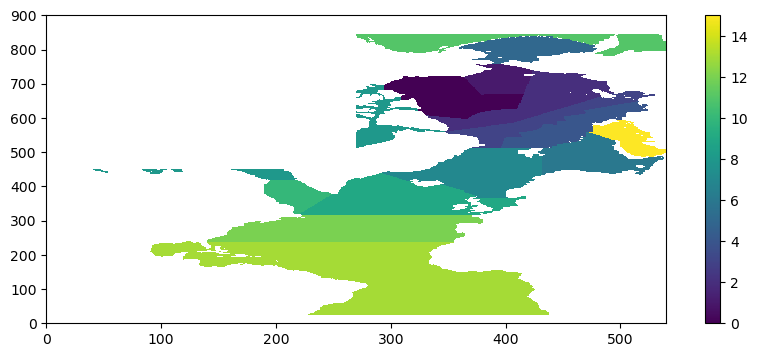

In [20]:
# load the whole Basin mask
# copy over the mask
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan


# extend the Barents Sea up to the gate between NZ--RU
mskBasin[mymsk == 1] = 6

ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

ind2d = mskBasin.reshape(364500)
ind2d.shape
# iBarentsS2D = np.where(ind2d == 7)[0]

mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

ind2d_wet = ind2d[iwetC2d]
iwet_BarentsS2D = np.where(ind2d_wet == 6)[0]
iwet_mine = iwet_BarentsS2D
imask = np.where(ind2d == -1)[0]
iwet_mymsk = np.where(ind2d_wet == 6)[0]

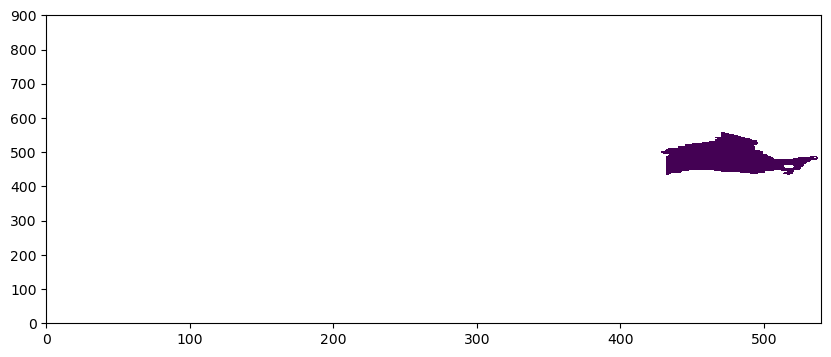

In [27]:
# define mymsk for the Barents Sea
mymsk = (mskBasin == 6).astype(float)
mymsk[mymsk == 0] = np.nan 
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])

In [42]:
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

In [3]:
# define the gateways
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_nzru = np.full((5),37)
y_nzru = np.arange(460,465,1)

gates = np.full(mskBasin.shape,np.nan)
gates[y_bso,x_bso] = 1
gates[y_sfj,x_sfj] = 2
gates[y_fjnz,x_fjnz] = 3
gates[y_nzru,x_nzru] = 4

## Process the mask for the polar front based on the SST gradient (this is what Ben Barton did)

In [5]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2006,2018,1)  # start from the beginning of the regime shift

In [7]:
# grab the SST to initialize the PF mask
# get the theta and salt for all years

all_SST = np.full((len(allyears),12,ny,nx),np.nan)

iy = 0
it = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    thisyear_SST = np.full((len(tsstr),ny,nx),np.nan)  # one year length
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    
        thisyear_SST[i,:,:] = np.reshape(THETAi,(nz,ny,nx))[0] # just add SST

    # get theta and salt alone so we can use for the freshwater content
    all_SST[iy,:,:,:] = thisyear_SST
    
    iy += 1



2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [127]:
# Compute PF masks for all-year mean and for each season (JFM, AMJ, JJA, SON)

DXG = get_aste_tracer(mygrid['DXG'], nfx, nfy)[0]
DYG = get_aste_tracer(mygrid['DYG'], nfx, nfy)[0]

def compute_pf_mask(SST_mean, DXG, DYG, hfC, nfx, nfy):
    """Helper to compute PF mask from mean SST field."""
    tracerSST = get_aste_tracer(SST_mean * hfC, nfx, nfy)[0]

    # Horizontal SST gradients
    dTdx = np.zeros_like(tracerSST)
    dTdx[:, 1:-1] = (tracerSST[:, 2:] - tracerSST[:, :-2]) / (DXG[:, 2:] + DXG[:, :-2])

    dTdy = np.zeros_like(tracerSST)
    dTdy[1:-1, :] = (tracerSST[2:, :] - tracerSST[:-2, :]) / (DYG[2:, :] + DYG[:-2, :])

    # Gradient magnitude (°C/m) -> °C/km
    grad_T = np.sqrt(dTdx**2 + dTdy**2) * 1000.0

    # Apply SST range mask and threshold
    mask = (tracerSST > -2) & (tracerSST < 4)
    return (grad_T * mask > 0.006).astype(np.uint8)

# Overall mean (all years, all months)
SST_mean_all = np.nanmean(all_SST, axis=tuple(range(all_SST.ndim - 2)))
pf_mask_all = compute_pf_mask(SST_mean_all, DXG, DYG, hfC, nfx, nfy)
print("Computed overall PF mask (all months, all years).")

# Seasonal means (assuming all_SST shape = (nyears, 12, ny, nx))
seasons = {
    "JFM": [0, 1, 2],
    "AMJ": [3, 4, 5],
    "JAS": [6, 7, 8],
    "OND": [9, 10, 11]
}
pf_masks_seasonal = {}

for season, months in seasons.items():
    SST_season = np.nanmean(all_SST[:, months, ...], axis=(0, 1))  # mean across years & season months
    pf_masks_seasonal[season] = compute_pf_mask(SST_season, DXG, DYG, hfC, nfx, nfy)
    print(f"Computed PF mask for {season}.")


Computed overall PF mask (all months, all years).
Computed PF mask for JFM.
Computed PF mask for AMJ.
Computed PF mask for JAS.
Computed PF mask for OND.


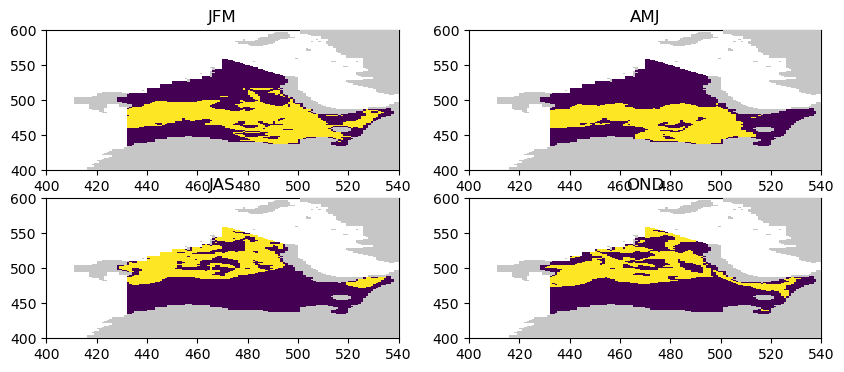

In [128]:
fig = plt.figure()
land_data = get_aste_tracer(landmsk, nfx, nfy)[0]

i = 1
for name in np.asarray(list(seasons.keys())):
    order = str(22) + str(i)
    ax = plt.subplot(int(order))
    ax.pcolormesh(pf_masks_seasonal[name] * get_aste_tracer(mymsk,nfx,nfy)[0])
    ax.set_xlim(400,540)
    ax.set_ylim(400,600)
    ax.pcolormesh(land_data, cmap="Greys", zorder=7, vmin=0, vmax=6)
    ax.set_title(name)
    i += 1

(400.0, 600.0)

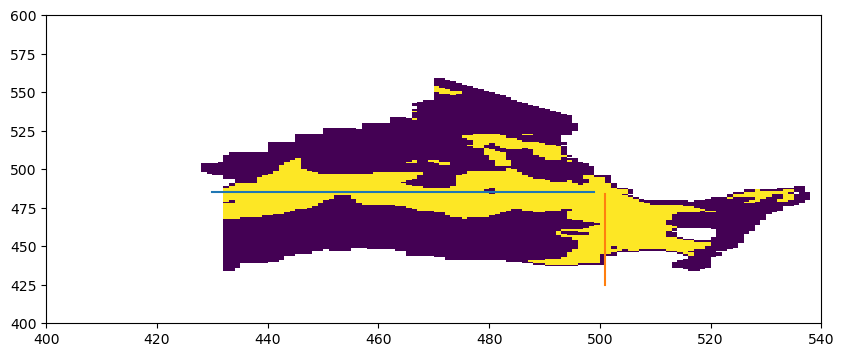

In [129]:
# define two masks based on this

fig = plt.figure()
ax = plt.subplot(111)
ax.pcolormesh(pf_mask_all * get_aste_tracer(mymsk,nfx,nfy)[0])
a = np.arange(430,500,1)
ax.plot(a,np.full(a.shape,485))
b = np.arange(425,485,1)
ax.plot(np.full(b.shape,501),b)

ax.set_xlim(400,540)
ax.set_ylim(400,600)

Text(0.5, 1.0, 'nmask = BarentsSea & isNaN(smask)')

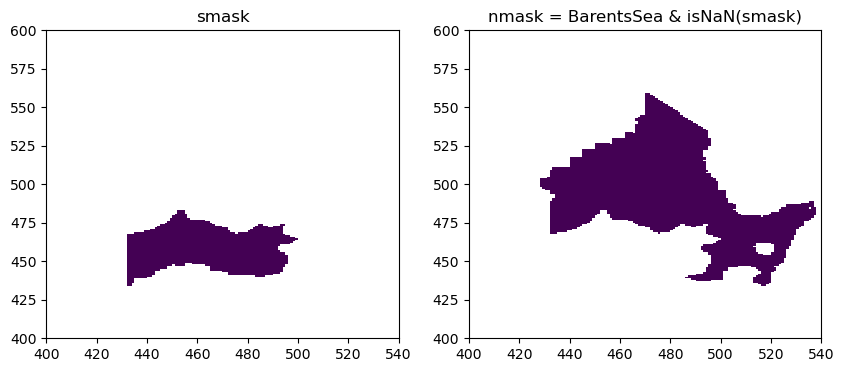

In [130]:
# create two new masks based on this average SST gradient ( this was defined based on 0.006 degC/km)
smask = pf_mask_all * get_aste_tracer(mymsk,nfx,nfy)[0]
smask[smask == 1] = np.nan  # mask the PF itself
smask[485:] = np.nan
smask[475:480,430:435] = np.nan
smask[:,501:] = np.nan
smask[475:490,475:483] = np.nan
smask[457:460,493:500] = np.nan
smask[430:440,483:505] = np.nan
smask[430:450,500:510] = np.nan

# inside-basin footprint on tracer grid
msk_tr = get_aste_tracer(mymsk, nfx, nfy)[0]   # 1 inside, NaN outside
base   = ~np.isnan(msk_tr)

# nmask: where mymsk==1 AND smask is NaN
nmask = np.where(base & np.isnan(smask), 1.0, np.nan)

# quick plot next to smask
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(121)
ax.pcolormesh(smask)
ax.set_xlim(400,540); ax.set_ylim(400,600); ax.set_title("smask")

ax = plt.subplot(122)
ax.pcolormesh(nmask)
ax.set_xlim(400,540); ax.set_ylim(400,600); ax.set_title("nmask = BarentsSea & isNaN(smask)")


In [131]:
# save these masks
# Save both masks in one file (compressed)
np.savez_compressed(
    "pf_masks_tracer.npz",
    smask=smask.astype(np.float32),
    nmask=nmask.astype(np.float32),
    cutoff=np.array(0.006, dtype=np.float32),  # optional metadata
)f

# Load later
with np.load("pf_masks_tracer.npz") as data:
    smask_loaded = data["smask"]
    nmask_loaded = data["nmask"]
    cutoff_used  = float(data["cutoff"])  # optional


## Let's look at each of the years to see if we can isolate the differences and see what this looks like

In [ ]:
# Overall mean (all years, all months)
SST_mean_all = np.nanmean(all_SST, axis=tuple(range(all_SST.ndim - 2)))
pf_mask_all = compute_pf_mask(SST_mean_all, DXG, DYG, hfC, nfx, nfy)


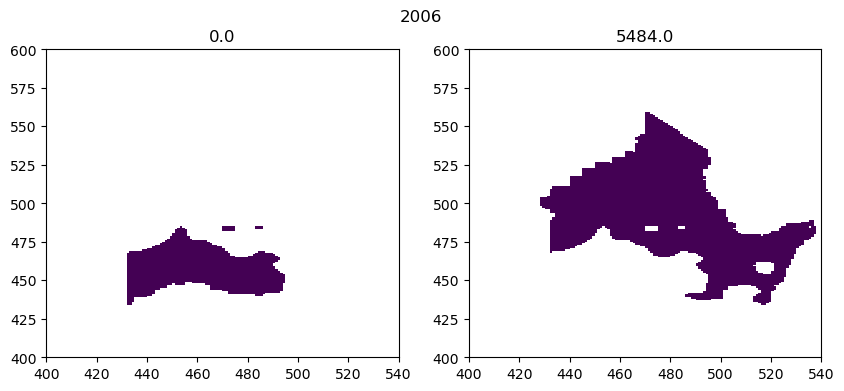

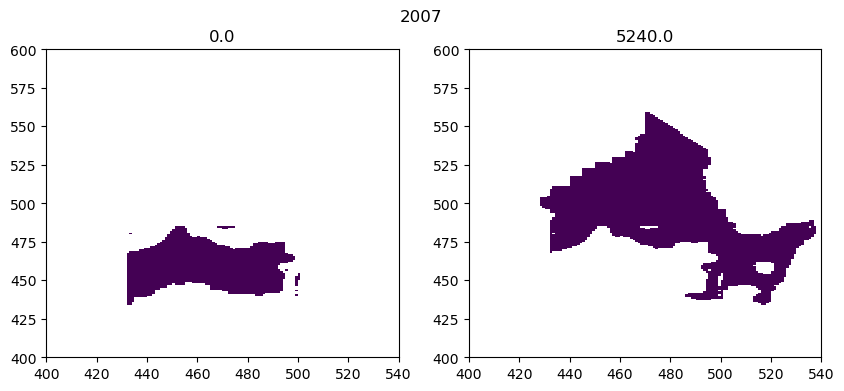

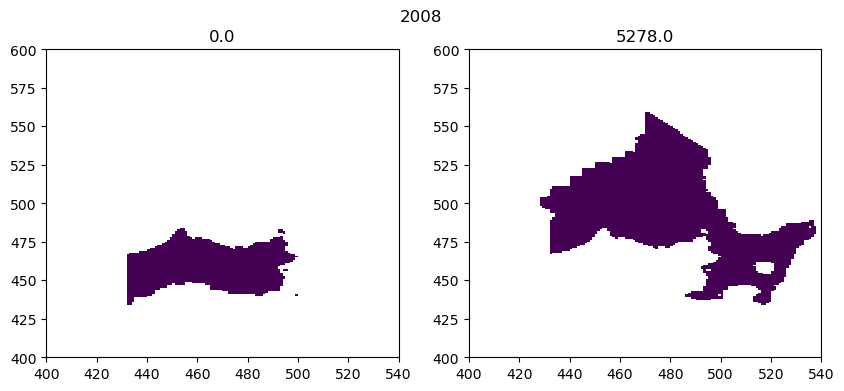

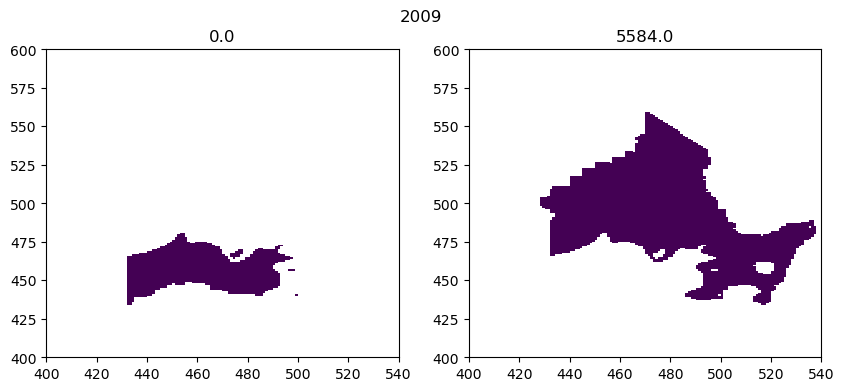

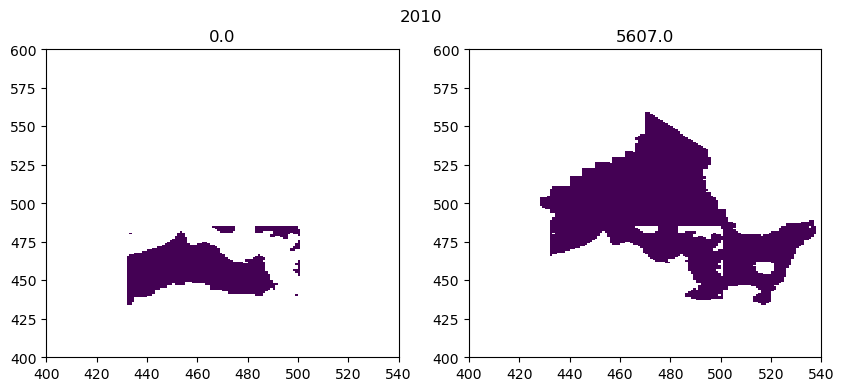

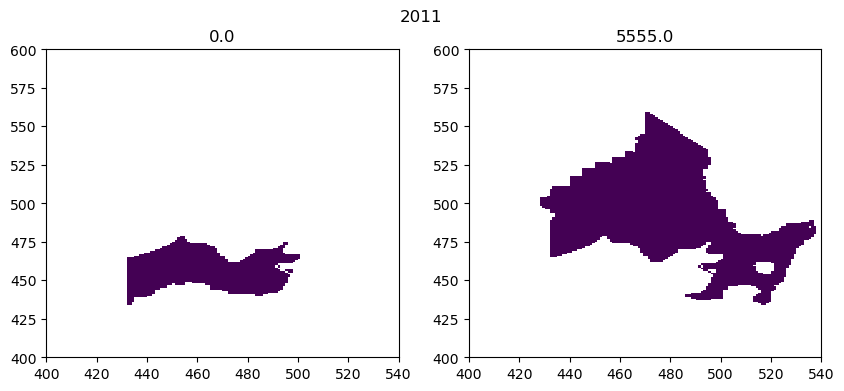

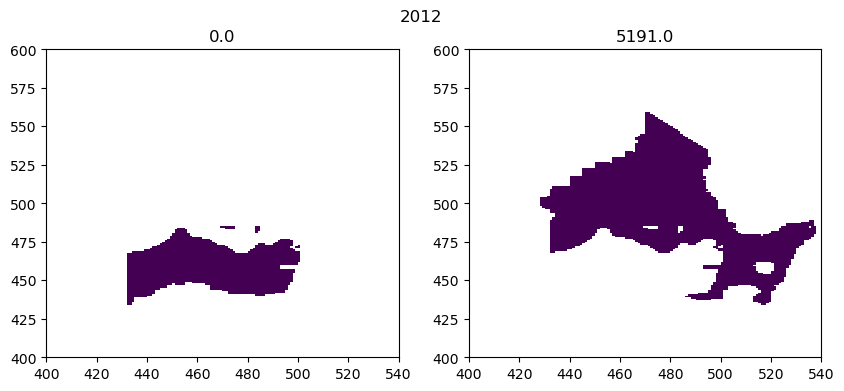

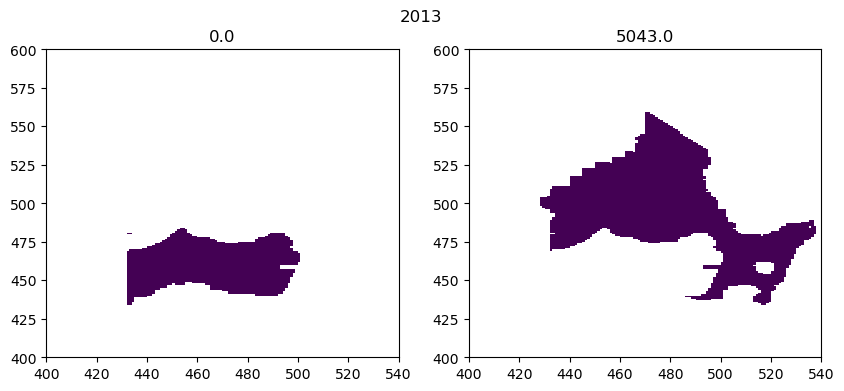

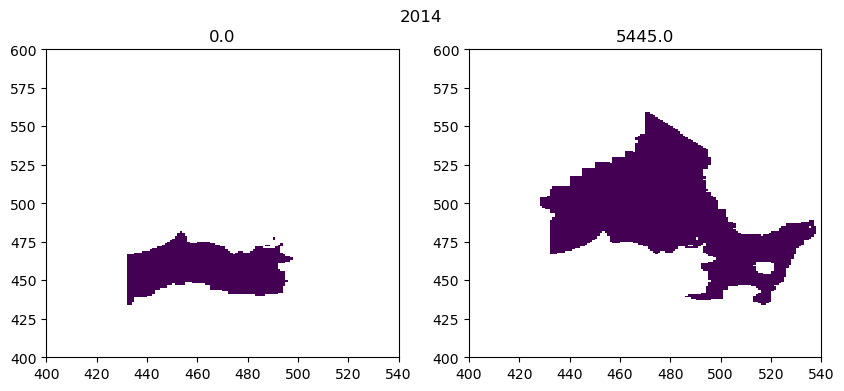

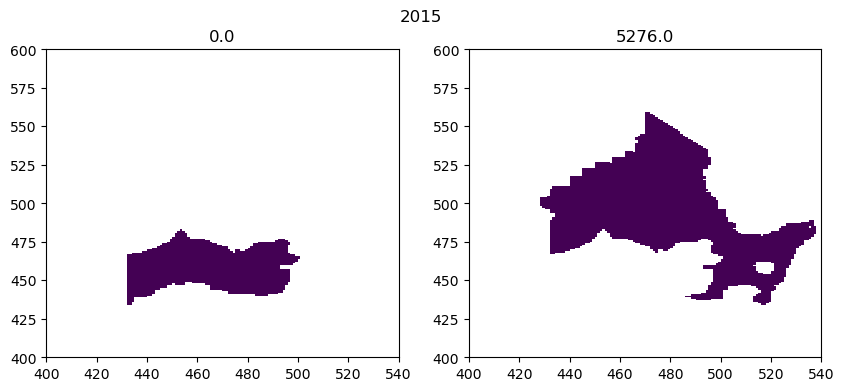

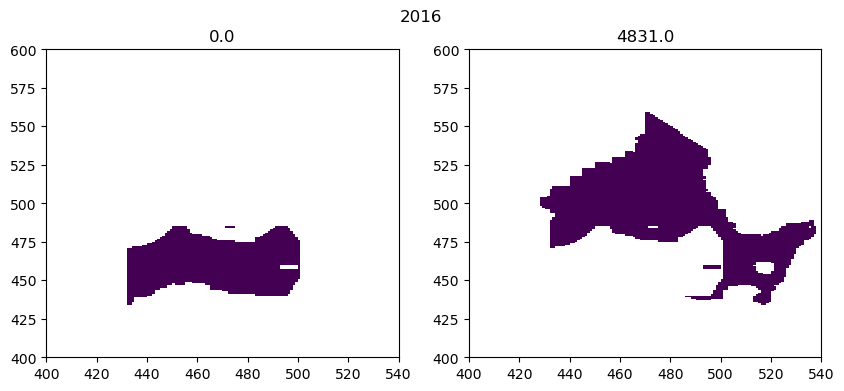

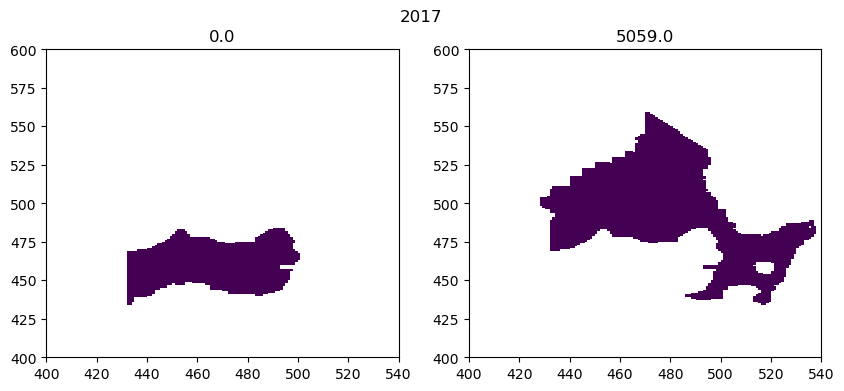

In [126]:
# loop through the years and calculate masks for each
for i in range(len(allyears)):
    SST_mean_year = np.nanmean(all_SST[i], axis=0) # average across the year
    pf_mask_year = compute_pf_mask(SST_mean_year, DXG, DYG, hfC, nfx, nfy)

    # create two new masks based on this average SST gradient ( this was defined based on 0.006 degC/km)
    smask = pf_mask_year * get_aste_tracer(mymsk,nfx,nfy)[0]
    smask[smask == 1] = np.nan  # mask the PF itself
    smask[485:] = np.nan
    smask[475:480,430:435] = np.nan
    smask[:,501:] = np.nan
    smask[475:490,475:483] = np.nan
    smask[457:460,493:500] = np.nan
    smask[430:440,483:505] = np.nan
    smask[430:450,500:510] = np.nan
    
    # inside-basin footprint on tracer grid
    msk_tr = get_aste_tracer(mymsk, nfx, nfy)[0]   # 1 inside, NaN outside
    base   = ~np.isnan(msk_tr)
    
    # nmask: where mymsk==1 AND smask is NaN
    nmask = np.where(base & np.isnan(smask), 1.0, np.nan)
    
    # quick plot next to smask
    fig = plt.figure(figsize=(10,4))
    ax = plt.subplot(121)
    ax.pcolormesh(smask)
    # get the size of the mask that we set
    sname = np.nansum(smask)
    ax.set_xlim(400,540); ax.set_ylim(400,600); ax.set_title(sname)
    
    ax = plt.subplot(122)
    ax.pcolormesh(nmask)
    nname = np.nansum(nmask)
    ax.set_xlim(400,540); ax.set_ylim(400,600); ax.set_title(nname)

    tyear = str(allyears[i])
    
    plt.suptitle(tyear)

## this appears largely consistent across the years so we can save the ones from the average of the years

In [ ]:
# I think we should save the original one that we made 